Group 5: raveel tejani, sam young

# Lab Notebook 15 - Clustering methods

In this notebook, we will learn how to write a **k-means++ clustering** code from scratch. We will test this code on two different data sets: one with spherically shaped clusters, and another with irregularly shaped clusters. Next, we will use **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)** on the same data sets, and determine which ML method is better.

## Step 1

Import the appropriate packages and, optionally, set your matplotlib.rc parameters.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams['figure.dpi'] = 100

## Step 2

Here is our first dataset. Make a scatter plot of the data points.

In [2]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate (approximately circular) data:
centers1 = 4
xvals1, true_labels1 = make_blobs(n_samples=100, centers=centers1, random_state=30,cluster_std=0.3)
xvals1 = StandardScaler().fit_transform(xvals1)

Here is our second dataset. Again make a scatter plot of the data.

In [3]:
# Generate (irregular) data:
centers2 = [[1, 0], [-1, -1], [1.5, -1.5]]
ncenters2 = 3
xvals2, true_labels2 = make_blobs(n_samples=100, centers=centers2, cluster_std=[0.4, 0.3, 0.85], random_state=0)

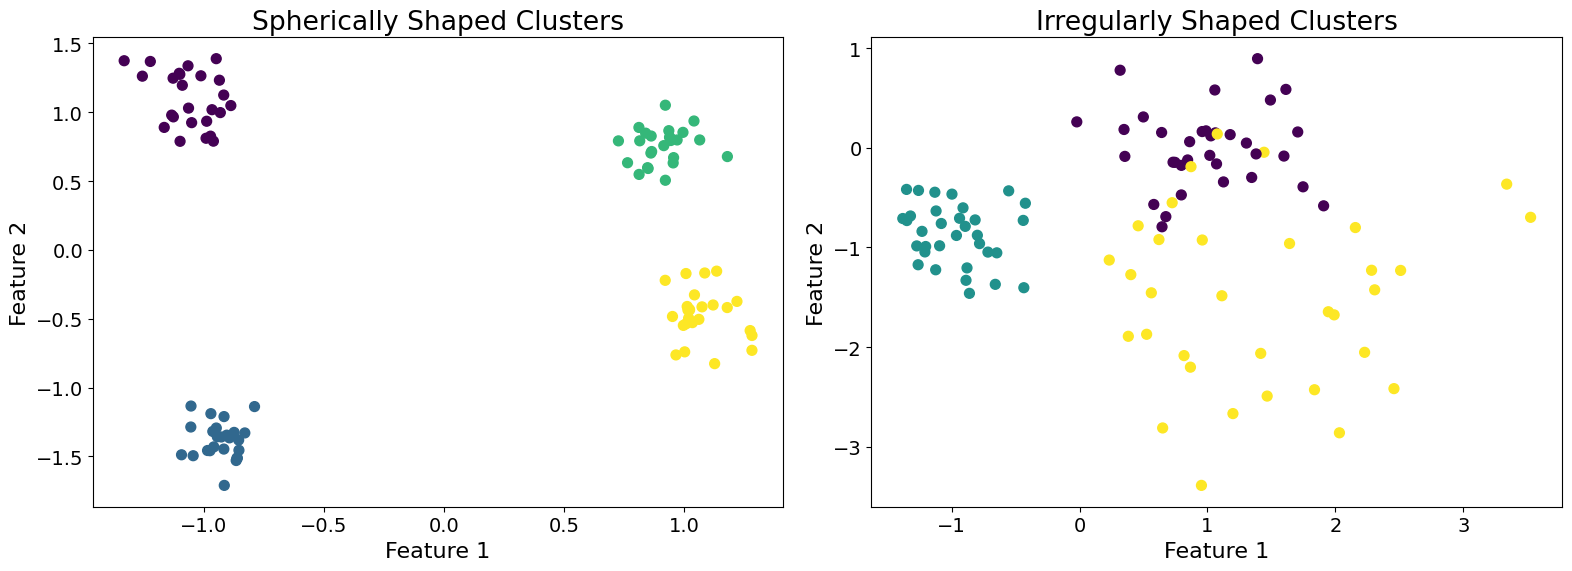

In [4]:
# Plotting the datasets
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Dataset 1: Spherically shaped clusters
ax[0].scatter(xvals1[:, 0], xvals1[:, 1], s=50, c=true_labels1, cmap='viridis')
ax[0].set_title('Spherically Shaped Clusters')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

# Dataset 2: Irregularly shaped clusters
ax[1].scatter(xvals2[:, 0], xvals2[:, 1], s=50, c=true_labels2, cmap='viridis')
ax[1].set_title('Irregularly Shaped Clusters')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## Step 3

Now we will write our k-means++ clustering algorithm. 

First, define a function called "euclidean" that intakes a point and a dataset of points, and returns the euclidean distance.
The point has dimensions (m,), the data has dimensions (n,m), and output will be of size (n,). You already wrote such a function for the knn algorithm in lab 3, feel free to import your code.

In [5]:
def euclidean(point, dataset):
    distances = np.sqrt(np.sum((dataset - point) ** 2, axis=1))
    return distances

Next, define the class "KMeans". Within this class, we have the following functions:

1. **\_\_init\_\_**, which has inputs self, n_clusters, and max_iter. You can set default values for n_clusters and max_iter if you wish. Let self.n_clusters = n_clusters and self.max_iter = max_iter.

2. **fit**, which has inputs self and X_train. This is the core of the kmeans algorithm.

3. **evaluate**, which intakes self and X. This function will evaluate the distance between a set of points and the centroids for which we’ve optimized our training set. This method returns classification labels, i.e. the index of the centroid to which each data point belongs. 

init and fit are already provided. You need to complete a few lines in **evaluate**

In [6]:
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
import random

class KMeans:
    def __init__(self, n_clusters=8, max_iter=300, random_state = 0): #added random_state for reproducibility
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
    def fit(self, X_train):
        # We provide the following code, also called the "k-means++" method, to initialize the centroids. 
        # A random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first point
        
        # Pick a random point from train data for first centroid
        np.random.seed(self.random_state) ## added for reproducibility
        self.centroids = [random.choice(X_train)]
        # Set the remaining initial guesses
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            np.random.seed(self.random_state) ## added for reproducibility
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
            
        # end of initialization
        
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        
        
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0 
        # initialize a counter for the number of iterations
        prev_centroids = None 
        #intialize an array prev_centroids = None
        # while centroids are changing and max_iter is not exceeded:
            
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # initialize and empty array sorted_points
            sorted_points = [[] for _ in range(self.n_clusters)]
            
            # loop over training set, compute distances data-centroids, find closest centroid for each data point, 
            # append data point to list belonging to that centroid            
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
                
            # Store current centroids in previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            
            # Restore previous centroid if new one has no points
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            # Increment counter
            iteration += 1
            
    def evaluate(self, X):
        #initialize an empty list for the indices of the centroids
        centroid_idxs = []
        #loop over all examples
        for x in X:
            # compute distances to all centroids
            distances = euclidean(x, self.centroids)
            
            # find the closest centroid for each data point
            closest_point = np.argmin(distances)
            
            # append index to list of indices
            centroid_idxs.append(closest_point)
            
        # return centroid indices
        return centroid_idxs

## Step 4

Test the code on dataset 1. Make a scatter plot of the data, color the data by classification label, and draw the positions of the centroids in a different symbol and color.

In [7]:
model1 = KMeans(n_clusters = 4)
model1.fit(xvals1)
y_pred1 = model1.evaluate(xvals1)
centroids1 = np.array(model1.centroids)

Repeat the above on dataset 2.

In [8]:
model2 = KMeans(n_clusters = 3)
model2.fit(xvals2)
y_pred2 = model2.evaluate(xvals2)
centroids2 = np.array(model2.centroids)

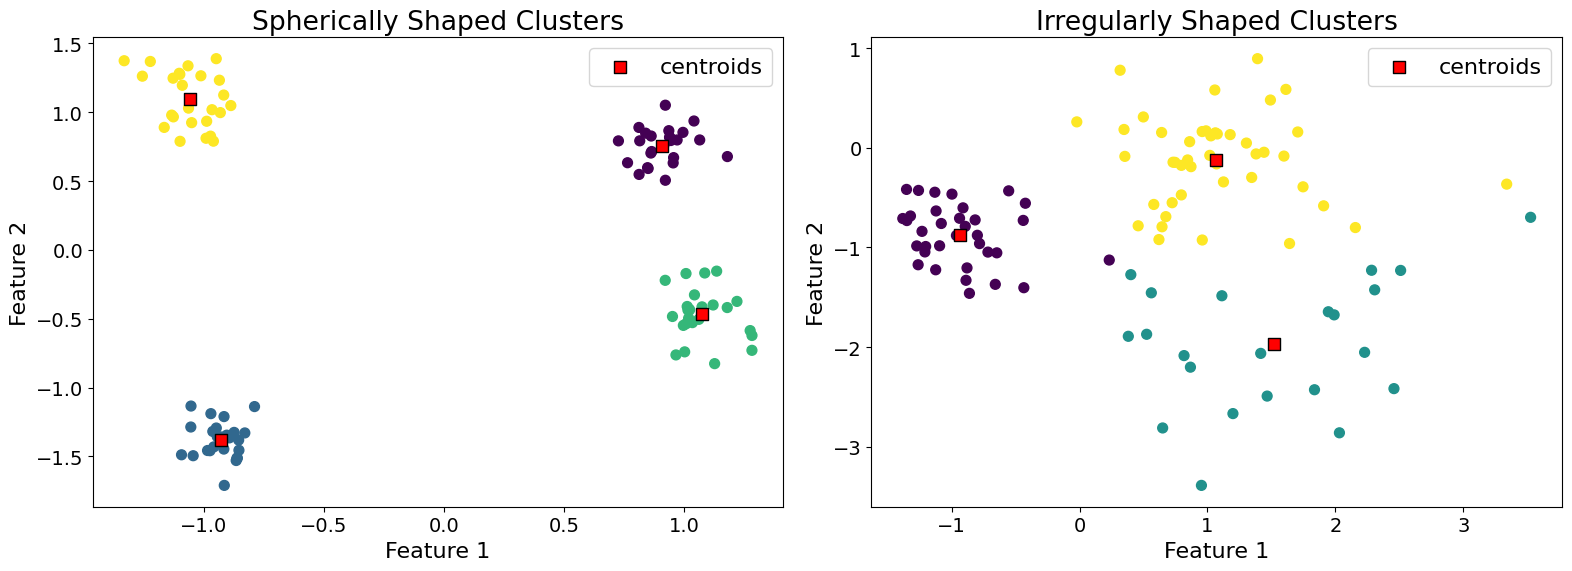

In [9]:
# Plotting the datasets
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Dataset 1: Spherically shaped clusters
ax[0].scatter(xvals1[:, 0], xvals1[:, 1], s=50, c=y_pred1, cmap='viridis')
ax[0].scatter(centroids1[:, 0], centroids1[:, 1], s=70, c='red', edgecolors = 'black', marker= 's', label = "centroids")
ax[0].set_title('Spherically Shaped Clusters')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[0].legend()



# Dataset 2: Irregularly shaped clusters
ax[1].scatter(xvals2[:, 0], xvals2[:, 1], s=50, c=y_pred2, cmap='viridis')
ax[1].scatter(centroids2[:, 0], centroids2[:, 1], s=70, c='red', edgecolors = 'black', marker= 's',label = "centroids")
ax[1].set_title('Irregularly Shaped Clusters')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
ax[1].legend()

plt.tight_layout()
plt.show()

## Step 5

Hopefully, your k-means+ code worked to find the centroids of Datasets 1 and 2. However, in real life your datasets will likely be more complicated. For instance, see the following "smiley face" data:

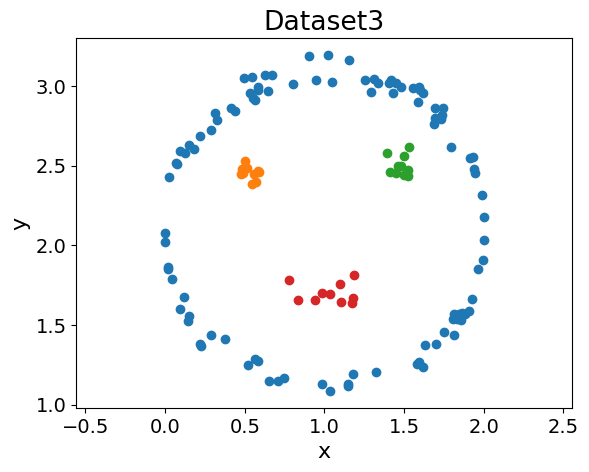

In [10]:
from math import pi, cos, sin
import random
np.random.seed(10)
def point(h, k, r):
    theta = random.random() * 2 * pi
    return h + cos(theta) * r, k + sin(theta) * r + 0.2*random.random()

# Generate points:
xy = [point(1,2,1) for _ in range(100)]

X1, y1 = make_blobs(n_samples=10, centers=[(0.5,2.5)],
                       cluster_std=0.05, random_state=1)

X2, y2 = make_blobs(n_samples=10, centers=[(1.5,2.5)],
                       cluster_std=0.05, random_state=2)

X3, y3 = make_blobs(n_samples=10, centers=[(1,1.7)],
                       cluster_std=0.05, random_state=2)

X3_stretch = np.array([X3[:,0]*3, X3[:,1]]) #make the mouth :) 


# Plot:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(*zip(*xy))
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.scatter(X3_stretch.T[:,0]-1.9,X3_stretch.T[:,1])

plt.title("Dataset3")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Try running your code on the "smiley face" dataset. Does your code accurately predict the centroids?

**it did not**

You will need to use the following line of code (or something similar) to turn the smiley face data arrays into one array, "xvals3":

    xvals3 = np.vstack([xy,X1,X2,np.array([X3_stretch.T[:,0]-1.9,X3_stretch.T[:,1]]).T])

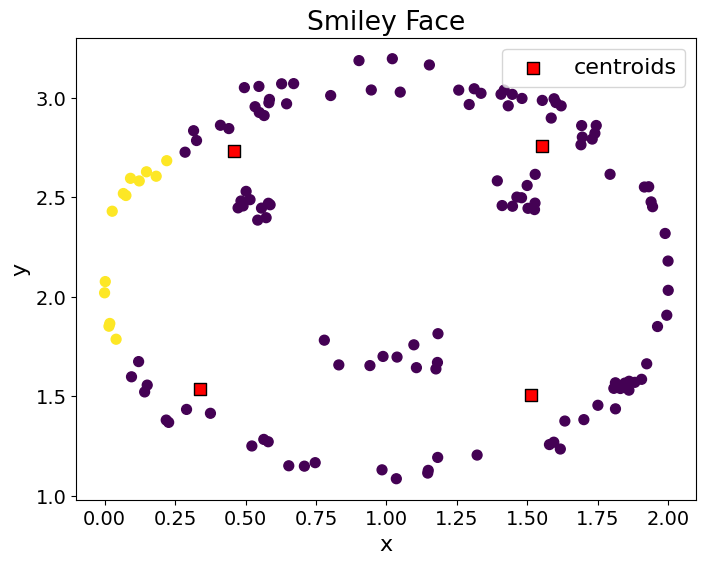

In [11]:
xvals3 = np.vstack([xy,X1,X2,np.array([X3_stretch.T[:,0]-1.9,X3_stretch.T[:,1]]).T])
model3 = KMeans(n_clusters = 4)
model3.fit(xvals3)
y_pred3 = model1.evaluate(xvals3)
centroids3 = np.array(model3.centroids)

# Plotting the datasets
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Dataset 1: Spherically shaped clusters
ax.scatter(xvals3[:, 0], xvals3[:, 1], s=50, c=y_pred3, cmap='viridis')
ax.scatter(centroids3[:, 0], centroids3[:, 1], s=70, c='red', edgecolors = 'black', marker= 's', label = "centroids")
ax.set_title('Smiley Face')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend()
plt.show()

Did the k-means++ code accurately predict the centroids? Why or why not?

**It does not predict it well because the model maximizes the distance between all the centroids in euclidean space. In the smiley face example, this would mean it has to pick centroids that are at the eyes, mouth and centre(for the circle outline). This is not feasible with this model as we see in the above plot, the distance between all centroids is maximized which would not accurately group the features of a smiley face. Particularly the issue lies withing the outline of the smiley face (the circle) as the points are not grouped based on proximity, but are instead grouped as the curve itself.**

## Step 6

Another method we can use is called **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**. For a a set of points in space, this algorithm groups the points that are closely packed together, and identifies points that lie in low-density regions as outliers.

From sklearn.cluster, import "DBSCAN". We will be using the "smiley face" data to test this method. Plot the data colored by cluster label. How many clusters does DBSCAN find? How does the answer depend on the parameter **eps**?

**eps controls how many clustering groups we have. Its value indicates the maximum distance between two points for the points to be placed in the same cluster. We illustrate that below by using three different eps values: 0.5(default), 0.26 and 0.1. the smaller the value the more clusters (labels) we have.**


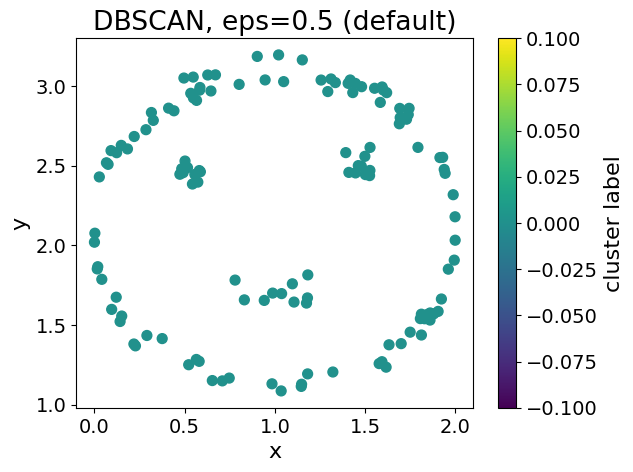

no. of clusters: 1


In [12]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN()
dbscan_labels = dbscan_model.fit_predict(xvals3)

plt.scatter(xvals3[:, 0], xvals3[:, 1], s=50, c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN, eps=0.5 (default)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label = 'cluster label')
plt.show()
print('no. of clusters: {}'.format(len(np.unique(dbscan_labels))))

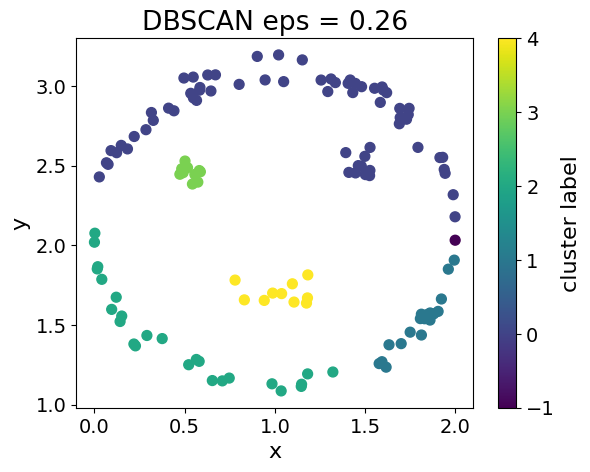

no. of clusters: 6


In [13]:
dbscan_model = DBSCAN(eps=0.26)
dbscan_labels = dbscan_model.fit_predict(xvals3)

plt.scatter(xvals3[:, 0], xvals3[:, 1], s=50, c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN eps = 0.26')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label = 'cluster label')
plt.show()
print('no. of clusters: {}'.format(len(np.unique(dbscan_labels))))

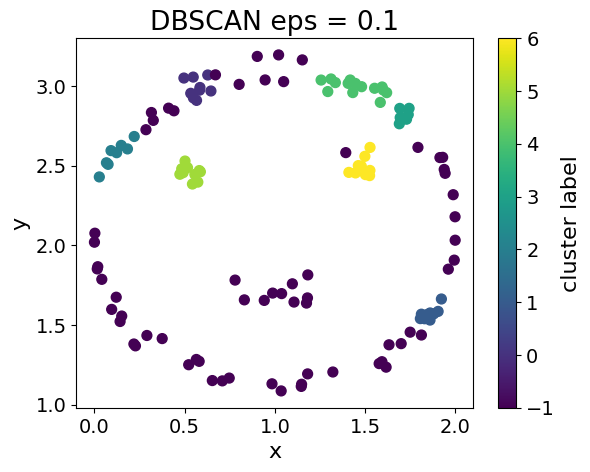

no. of clusters: 8


In [14]:
dbscan_model = DBSCAN(eps=0.1)
dbscan_labels = dbscan_model.fit_predict(xvals3)



plt.scatter(xvals3[:, 0], xvals3[:, 1], s=50, c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN eps = 0.1')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label = 'cluster label')
plt.show()
print('no. of clusters: {}'.format(len(np.unique(dbscan_labels))))